In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 10 10:59:39 2019

@author: Katherine, Ki Wan
"""

import csv
import os
from functools import partial
import json
import numpy as np
import geopandas as gpd
import matplotlib

import matplotlib.pyplot as plt
#import seaborn as sns
import networkx as nx
import random


from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)
from gerrychain.metrics import efficiency_gap, mean_median, partisan_gini
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part
from gerrychain.accept import always_accept



In [2]:
num_districts = 56
output_dirname = "Run_1"

newdir = "./Outputs/"
os.makedirs(os.path.dirname(newdir + "init.txt"), exist_ok=True)
with open(newdir + "init.txt", "w") as f:
    f.write("Created Folder")
    
graph = Graph.from_json("./data/ga_tract.json") # run tract_data_prep.py
df = gpd.read_file("./data/ga_2012_tract.shp") #run dual_graph_tract.py


In [3]:
# SUMMING DATA WE WANT IN THE DATAFRAME
import pandas as pd 
new_cols = ['CPOP', 'VAP', 'BVAP', 'nBVAP', 'BHVAP', 'nBHVAP', 'CVAP', 'BCVAP', 'nBCVAP', 'BHCVAP', 'nBHCVAP']

VAP_cols = ['MVAPTOT', 'FVAPTOT']
BVAP_cols = ['MVAPBLK', 'FVAPBLK']
HVAP_cols = ['MVAPHISP', 'FVAPHISP']
CVAP_cols = ['MNVVAPTOT', 'MNLVAPTOT', 'FNVVAPTOT', 'FNLVAPTOT']
BCVAP_cols = ['MNVVAPBLK', 'MNLVAPBLK', 'FNVVAPBLK', 'FNLVAPBLK']
HCVAP_cols = ['MNVVAPHISP', 'MNLVAPHISP', 'FNVVAPHISP', 'FNLVAPHISP']


df['CPOP'] = pd.to_numeric(df['TOTPOP']-df['NCPOP'])
df['VAP'] = pd.to_numeric(df[VAP_cols].sum(axis=1))
df['BVAP'] = pd.to_numeric(df[BVAP_cols].sum(axis=1))
df['nBVAP'] = df['VAP'] - df['BVAP']
df['CVAP'] = pd.to_numeric(df[CVAP_cols].sum(axis=1))
df['BCVAP'] = pd.to_numeric(df[BCVAP_cols].sum(axis=1))
df['nBCVAP'] = df['CVAP'] - df['BCVAP']

df['BHVAP'] = pd.to_numeric(df['BVAP'] + df[HVAP_cols].sum(axis=1))
df['nBHVAP'] = df['VAP'] - df['BHVAP']
df['BHCVAP'] = pd.to_numeric(df['BCVAP'] + df[HCVAP_cols].sum(axis=1))
df['nBHCVAP'] = df['CVAP'] - df['BHCVAP']

In [4]:
# ADD NEW DATA TO GRAPH 

graph.add_data(df, columns=new_cols)

## Chain on TOTPOP

In [6]:
# INITIAL PARTITION ASSIGNMENT USING RECURSIVE TREE PARTITION

starts = []

for i in range(1):
    starts.append(recursive_tree_part(graph,range(num_districts),df['TOTPOP'].sum()/num_districts, "TOTPOP", .01, 1))


In [7]:
updater = {
    "population": updaters.Tally("TOTPOP", alias="population"),
    "cut_edges": cut_edges,
    "BVAP":Election("BVAP",{"BVAP":"BVAP","nBVAP":"nBVAP"}),
    "BCVAP":Election("BCVAP",{"BCVAP":"BCVAP","nBCVAP":"nBCVAP"}),
    "BHVAP":Election("BHVAP",{"BHVAP":"BHVAP","nBHVAP":"nBHVAP"}),
    "BHCVAP":Election("BHCVAP",{"BHCVAP":"BHCVAP","nBHCVAP":"nBHCVAP"})
}

initial_partitions = []
proposals = []
compactness_bounds = []
chains=[]

for i in range(1):
    initial_partitions.append(Partition(graph,starts[i], updater))
    print("initial partition is made")

    proposals.append(partial(
        recom, pop_col="TOTPOP", pop_target=df['TOTPOP'].sum()/num_districts, epsilon= .05, node_repeats=1 # e = .02
    ))

    compactness_bounds.append(constraints.UpperBound(
        lambda p: len(p["cut_edges"]), 2 * len(initial_partitions[i]["cut_edges"])
    ))

    chains.append(MarkovChain(
        proposal=proposals[i],
        constraints=[
            constraints.within_percent_of_ideal_population(initial_partitions[i], .05), compactness_bounds[i] # e = .05
          #constraints.single_flip_contiguous#no_more_discontiguous 
        #constraints.within_percent_of_ideal_population(initial_partitions[i], .3)
        ],
        accept=always_accept,
        initial_state=initial_partitions[i],
        total_steps=10000
    ))


initial partition is made


In [14]:
cuts=[[],[],[],[]]
BVAPS=[[],[],[],[]]
BCVAPS=[[],[],[],[]]
BHVAPS=[[],[],[],[]]
BHCVAPS=[[],[],[],[]]
BMM_dist=[[],[]]
BCMM_dist=[[],[]]
BHMM_dist=[[],[]]
BHCMM_dist=[[],[]]

# GA Senate as of 2019: 21 Dem, 35 Rep
currentD = 21

subdir = "./Outputs/Tract_Senate_TOTPOP/"
os.makedirs(os.path.dirname(subdir + "init.txt"), exist_ok=True)
with open(subdir + "init.txt", "w") as f:
    f.write("Created Folder")

outputdir_BVAP = './Outputs/Tract_Senate_TOTPOP/BVAP_Better_Than_Current/'
outputdir_minVAP =  './Outputs/Tract_Senate_TOTPOP/minVAP_Better_Than_Current/'

for i in range(1):
    t = 0
    for part in chains[i]:
        cuts[i].append(len(part["cut_edges"]))
        BVAPS[i].append(sorted(part["BVAP"].percents("BVAP")))
        BCVAPS[i].append(sorted(part["BCVAP"].percents("BCVAP")))
        BHVAPS[i].append(sorted(part["BHVAP"].percents("BHVAP")))
        BHCVAPS[i].append(sorted(part["BHCVAP"].percents("BHCVAP")))

        num_BMM_dist = part["BVAP"].seats("BVAP")
        BMM_dist[i].append(num_BMM_dist)
        
        num_BCMM_dist = part["BCVAP"].seats("BCVAP")
        BCMM_dist[i].append(num_BCMM_dist)
        
        num_BHMM_dist = part["BHVAP"].seats("BHVAP")
        BHMM_dist[i].append(num_BHMM_dist)
        
        num_BHCMM_dist = part["BHCVAP"].seats("BHCVAP")
        BHCMM_dist[i].append(num_BHCMM_dist)
        t+=1
    
        if (num_BMM_dist > currentD):
            print("chain",i,"step",t, "num_BMM_dist >", currentD)
            
            df.plot(column="current",cmap="jet")
            plt.savefig(outputdir_BVAP+"plot_BMM_"+str(t)+".png")
            plt.close()

            with open(outputdir_BVAP+"assignment_BMM_"+str(t)+".json", 'w') as jf1:
                json.dump(dict(part.assignment), jf1)
        
        if (num_BHMM_dist > currentD):
            print("chain",i,"step",t, "num_BHMM_dist >", currentD)
            
            df.plot(column="current",cmap="jet")
            plt.savefig(outputdir_minVAP+"plot_BHMM_"+str(t)+".png")
            plt.close()

            with open(outputdir_minVAP+"assignment_BHMM_"+str(t)+".json", 'w') as jf1:
                json.dump(dict(part.assignment), jf1)
    
        if t%100 ==0:
            print("chain",i,"step",t)
            
    print(f"finished chain {i}")

df["final"]=df.index.map(dict(part.assignment))

df.plot(column="final",cmap="jet")
plt.savefig(subdir+"final.png")
plt.close()


chain 0 step 100
chain 0 step 200
chain 0 step 300
chain 0 step 400
chain 0 step 500
chain 0 step 600
chain 0 step 700
chain 0 step 800
chain 0 step 900
chain 0 step 1000
chain 0 step 1100
chain 0 step 1200
chain 0 step 1300
chain 0 step 1400
chain 0 step 1500
chain 0 step 1600
chain 0 step 1700
chain 0 step 1800
chain 0 step 1900
chain 0 step 2000
chain 0 step 2100
chain 0 step 2200
chain 0 step 2300
chain 0 step 2400
chain 0 step 2500
chain 0 step 2600
chain 0 step 2700
chain 0 step 2800
chain 0 step 2900
chain 0 step 3000
chain 0 step 3100
chain 0 step 3200
chain 0 step 3300
chain 0 step 3400
chain 0 step 3500
chain 0 step 3600
chain 0 step 3700
chain 0 step 3800
chain 0 step 3900
chain 0 step 4000
chain 0 step 4100
chain 0 step 4200
chain 0 step 4300
chain 0 step 4400
chain 0 step 4500
chain 0 step 4600
chain 0 step 4700
chain 0 step 4800
chain 0 step 4900
chain 0 step 5000
chain 0 step 5100
chain 0 step 5200
chain 0 step 5300
chain 0 step 5400
chain 0 step 5500
chain 0 step 5600
c

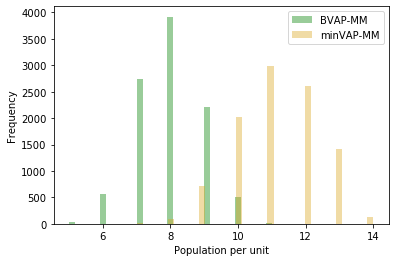

In [16]:
import seaborn as sns

colors = ['green', 'goldenrod']
labels= ['BVAP-MM', 'minVAP-MM']
plt.figure()

plt_1 = sns.distplot(BMM_dist[i],kde=False, color=colors[0],label=labels[0])
plt_2 = sns.distplot(BHMM_dist[i], kde=False, color=colors[1],label=labels[1])
#plt_1.set_yscale('log')
#plt_2.set_yscale('log')


plt.legend()
plt.ylabel("Frequency")
plt.xlabel("Population per unit")
plt.show()



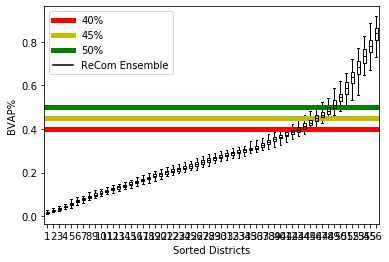

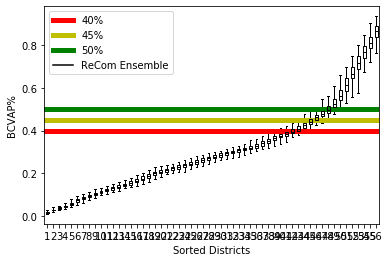

In [17]:
# PLOT SORTED DISTRICTS OVER BVAP %

c='k'

#37 to 55 is opportunity district BVAP range in VA

plt.figure()
plt.boxplot(
            np.array(BVAPS[0]),
            whis=[1, 99],
            showfliers=False,
            patch_artist=True,
            boxprops=dict(facecolor="None", color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
)

#plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13], enacted_CD112_BVAP, 'o', color="hotpink", label="Enacted (2012)",markersize=10)

plt.axhline(y=.4,color='r',label="40%",linewidth=5)

plt.axhline(y=.45,color='y',label="45%",linewidth=5)

plt.axhline(y=.5,color='g',label="50%",linewidth=5)
plt.plot([],[],color='k',label="ReCom Ensemble")
plt.xlabel("Sorted Districts")
plt.ylabel("BVAP%")

plt.legend()

plt.show()


# PLOT SORTED DISTRICTS OVER CBVAP %

plt.figure()
plt.boxplot(
            np.array(BCVAPS[0]),
            whis=[1, 99],
            showfliers=False,
            patch_artist=True,
            boxprops=dict(facecolor="None", color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
)

#plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13], enacted_CD112_BCVAP, 'o', color="hotpink", label="Enacted (2012)",markersize=10)

plt.axhline(y=.4,color='r',label="40%",linewidth=5)

plt.axhline(y=.45,color='y',label="45%",linewidth=5)

plt.axhline(y=.5,color='g',label="50%",linewidth=5)
plt.plot([],[],color='k',label="ReCom Ensemble")
plt.xlabel("Sorted Districts")
plt.ylabel("BCVAP%")

plt.legend()

plt.show()

## Chain on CPOP

In [19]:
# INITIAL PARTITION ASSIGNMENT USING RECURSIVE TREE PARTITION

CPOP_starts = []

for i in range(1):
    CPOP_starts.append(recursive_tree_part(graph,range(num_districts),df['CPOP'].sum()/num_districts, "CPOP", .01, 1))


In [20]:
CPOP_updater = {
    "population": updaters.Tally("CPOP", alias="population"),
    "cut_edges": cut_edges,
    "BVAP":Election("BVAP",{"BVAP":"BVAP","nBVAP":"nBVAP"}),
    "BCVAP":Election("BCVAP",{"BCVAP":"BCVAP","nBCVAP":"nBCVAP"}),
    "BHVAP":Election("BHVAP",{"BHVAP":"BHVAP","nBHVAP":"nBHVAP"}),
    "BHCVAP":Election("BHCVAP",{"BHCVAP":"BHCVAP","nBHCVAP":"nBHCVAP"})
}

CPOP_initial_partitions = []
CPOP_proposals = []
CPOP_compactness_bounds = []
CPOP_chains=[]

for i in range(1):
    CPOP_initial_partitions.append(Partition(graph,CPOP_starts[i], CPOP_updater))
    print("initial partition is made")

    CPOP_proposals.append(partial(
        recom, pop_col="CPOP", pop_target=df['CPOP'].sum()/num_districts, epsilon= .05, node_repeats=1 # e = .02
    ))

    CPOP_compactness_bounds.append(constraints.UpperBound(
        lambda p: len(p["cut_edges"]), 2 * len(initial_partitions[i]["cut_edges"])
    ))

    CPOP_chains.append(MarkovChain(
        proposal=CPOP_proposals[i],
        constraints=[
            constraints.within_percent_of_ideal_population(CPOP_initial_partitions[i], .05), CPOP_compactness_bounds[i] # e = .05
          #constraints.single_flip_contiguous#no_more_discontiguous 
        #constraints.within_percent_of_ideal_population(initial_partitions[i], .3)
        ],
        accept=always_accept,
        initial_state=CPOP_initial_partitions[i],
        total_steps=10000
    ))


initial partition is made


In [21]:
new_cuts=[[],[],[],[]]
new_BVAPS=[[],[],[],[]]
new_BCVAPS=[[],[],[],[]]
new_BHVAPS=[[],[],[],[]]
new_BHCVAPS=[[],[],[],[]]
new_BMM_dist=[[],[]]
new_BCMM_dist=[[],[]]
new_BHMM_dist=[[],[]]
new_BHCMM_dist=[[],[]]

# GA Senate as of 2019: 21 Dem, 35 Rep
currentD = 21

subdir = "./Outputs/Tract_Senate_CPOP/"
os.makedirs(os.path.dirname(subdir + "init.txt"), exist_ok=True)
with open(subdir + "init.txt", "w") as f:
    f.write("Created Folder")

outputdir_BVAP = './Outputs/Tract_Senate_CPOP/BVAP_Better_Than_Current/'
outputdir_minVAP =  './Outputs/Tract_Senate_CPOP/minVAP_Better_Than_Current/'

for i in range(1):
    t = 0
    for part in CPOP_chains[i]:
        new_cuts[i].append(len(part["cut_edges"]))
        new_BVAPS[i].append(sorted(part["BVAP"].percents("BVAP")))
        new_BCVAPS[i].append(sorted(part["BCVAP"].percents("BCVAP")))
        new_BHVAPS[i].append(sorted(part["BHVAP"].percents("BHVAP")))
        new_BHCVAPS[i].append(sorted(part["BHCVAP"].percents("BHCVAP")))

        num_BMM_dist = part["BVAP"].seats("BVAP")
        new_BMM_dist[i].append(num_BMM_dist)
        
        num_BCMM_dist = part["BCVAP"].seats("BCVAP")
        new_BCMM_dist[i].append(num_BCMM_dist)
        
        num_BHMM_dist = part["BHVAP"].seats("BHVAP")
        new_BHMM_dist[i].append(num_BHMM_dist)
        
        num_BHCMM_dist = part["BHCVAP"].seats("BHCVAP")
        new_BHCMM_dist[i].append(num_BHCMM_dist)
        t+=1
    
        if (num_BMM_dist > currentD):
            print("chain",i,"step",t, "num_BMM_dist >", currentD)
            
            df.plot(column="current",cmap="jet")
            plt.savefig(outputdir_BVAP+"plot_BMM_"+str(t)+".png")
            plt.close()

            with open(outputdir_BVAP+"assignment_BMM_"+str(t)+".json", 'w') as jf1:
                json.dump(dict(part.assignment), jf1)
        
        if (num_BHMM_dist > currentD):
            print("chain",i,"step",t, "num_BHMM_dist >", currentD)
            
            df.plot(column="current",cmap="jet")
            plt.savefig(outputdir_minVAP+"plot_BHMM_"+str(t)+".png")
            plt.close()

            with open(outputdir_minVAP+"assignment_BHMM_"+str(t)+".json", 'w') as jf1:
                json.dump(dict(part.assignment), jf1)
    
        if t%100 ==0:
            print("chain",i,"step",t)
            
    print(f"finished chain {i}")

df["final"]=df.index.map(dict(part.assignment))

df.plot(column="final",cmap="jet")
plt.savefig(subdir+"final.png")
plt.close()


chain 0 step 100
chain 0 step 200
chain 0 step 300
chain 0 step 400
chain 0 step 500
chain 0 step 600
chain 0 step 700
chain 0 step 800
chain 0 step 900
chain 0 step 1000
chain 0 step 1100
chain 0 step 1200
chain 0 step 1300
chain 0 step 1400
chain 0 step 1500
chain 0 step 1600
chain 0 step 1700
chain 0 step 1800
chain 0 step 1900
chain 0 step 2000
chain 0 step 2100
chain 0 step 2200
chain 0 step 2300
chain 0 step 2400
chain 0 step 2500
chain 0 step 2600
chain 0 step 2700
chain 0 step 2800
chain 0 step 2900
chain 0 step 3000
chain 0 step 3100
chain 0 step 3200
chain 0 step 3300
chain 0 step 3400
chain 0 step 3500
chain 0 step 3600
chain 0 step 3700
chain 0 step 3800
chain 0 step 3900
chain 0 step 4000
chain 0 step 4100
chain 0 step 4200
chain 0 step 4300
chain 0 step 4400
chain 0 step 4500
chain 0 step 4600
chain 0 step 4700
chain 0 step 4800
chain 0 step 4900
chain 0 step 5000
chain 0 step 5100
chain 0 step 5200
chain 0 step 5300
chain 0 step 5400
chain 0 step 5500
chain 0 step 5600
c

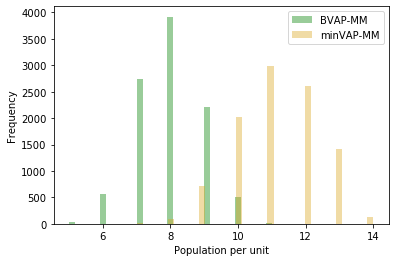

In [22]:
import seaborn as sns

colors = ['green', 'goldenrod']
labels= ['BVAP-MM', 'minVAP-MM']
plt.figure()

plt_1 = sns.distplot(BMM_dist[i],kde=False, color=colors[0],label=labels[0])
plt_2 = sns.distplot(BHMM_dist[i], kde=False, color=colors[1],label=labels[1])
#plt_1.set_yscale('log')
#plt_2.set_yscale('log')


plt.legend()
plt.ylabel("Frequency")
plt.xlabel("Population per unit")
plt.show()



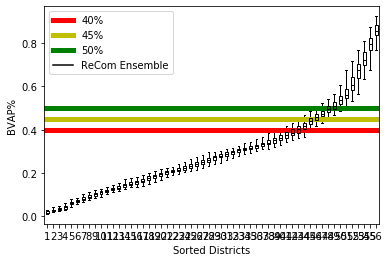

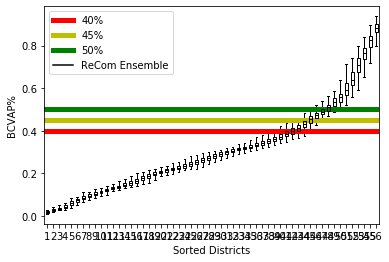

In [24]:
# PLOT SORTED DISTRICTS OVER BVAP %

c='k'

#37 to 55 is opportunity district BVAP range in VA

plt.figure()
plt.boxplot(
            np.array(new_BVAPS[0]),
            whis=[1, 99],
            showfliers=False,
            patch_artist=True,
            boxprops=dict(facecolor="None", color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
)

#plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13], enacted_CD112_BVAP, 'o', color="hotpink", label="Enacted (2012)",markersize=10)

plt.axhline(y=.4,color='r',label="40%",linewidth=5)

plt.axhline(y=.45,color='y',label="45%",linewidth=5)

plt.axhline(y=.5,color='g',label="50%",linewidth=5)
plt.plot([],[],color='k',label="ReCom Ensemble")
plt.xlabel("Sorted Districts")
plt.ylabel("BVAP%")

plt.legend()

plt.show()


# PLOT SORTED DISTRICTS OVER CBVAP %

plt.figure()
plt.boxplot(
            np.array(new_BCVAPS[0]),
            whis=[1, 99],
            showfliers=False,
            patch_artist=True,
            boxprops=dict(facecolor="None", color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
)

#plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13], enacted_CD112_BCVAP, 'o', color="hotpink", label="Enacted (2012)",markersize=10)

plt.axhline(y=.4,color='r',label="40%",linewidth=5)

plt.axhline(y=.45,color='y',label="45%",linewidth=5)

plt.axhline(y=.5,color='g',label="50%",linewidth=5)
plt.plot([],[],color='k',label="ReCom Ensemble")
plt.xlabel("Sorted Districts")
plt.ylabel("BCVAP%")

plt.legend()

plt.show()

In [39]:
#  things to change:
#  obj = {"[replace]_based_[replace]" : list(np.array(REPLACE).flatten())}

outputdir = './Outputs/'
obj = {"CPOP_based_BVAP" : list(np.array(new_BVAPS[0]).flatten())}

with open(outputdir+"CD13_CPOP_based_BVAP.json", 'w') as jf1:
    json.dump(dict(obj), jf1)
  